# Forecasting Renewable Energy Output Using Long-Short Term Memory and Convolutional Neural Networks

## Import all the needed packages

In [17]:
import numpy as np
import pandas as pd

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.layers import Conv1D, BatchNormalization, Input, Dense, Flatten, LSTM, Reshape, TimeDistributed
from tensorflow.keras.models import Model

import matplotlib.pyplot as plt

from sklearn.preprocessing import StandardScaler

from tensorflow.keras.utils import plot_model

from utility_functions import metrics

import warnings
warnings.filterwarnings("ignore")

## Import the data and split into Train, Test and Validation
- Fetch the first 70% records as train and the rest 15% each as validation and test
    - 8711 * 70% = 6097 records from the start (Train)
    - 6097 + 1307 = 6098 to 7404 records as (Validation)
    - 7404 + 1307 = 7405 to 8711 records as (Test)

In [18]:
dataset = pd.read_csv('dataset.csv',parse_dates=[0], index_col=0)

train = dataset[:6097]
valid = dataset[6097:7404]
test = dataset[7404:]

scaler = StandardScaler()

X_solar_train = train[['SWTDN', 'SWGDN', 'T', 'p']]
y_solar_train = train['DE_solar_generation_actual']
X_solar_valid = valid[['SWTDN', 'SWGDN', 'T', 'p']]
y_solar_valid = valid['DE_solar_generation_actual']
X_solar_test = test[['SWTDN', 'SWGDN', 'T', 'p']]
y_solar_test = test['DE_solar_generation_actual']

X_wind_train = scaler.fit_transform(train[['v1', 'v2', 'v_50m', 'z0']])
y_wind_train = scaler.fit_transform(train['DE_wind_generation_actual'].values.reshape(-1,1))
X_wind_valid = scaler.fit_transform(valid[['v1', 'v2', 'v_50m', 'z0']])
y_wind_valid = scaler.fit_transform(valid['DE_wind_generation_actual'].values.reshape(-1,1))
X_wind_test = scaler.fit_transform(test[['v1', 'v2', 'v_50m', 'z0']])
y_wind_test = scaler.fit_transform(test['DE_wind_generation_actual'].values.reshape(-1,1))

## Building a CNN + LSTM TensorFlow Model using Conv1D and LSTM for prediction

In [19]:
digit_a = Input(shape=(4,))

x = Reshape((-1,1))(digit_a)

x = Conv1D(128, 2)(x)
x = BatchNormalization()(x)
x = Conv1D(128, 2)(x)
x = BatchNormalization()(x)
x = Conv1D(128, 2)(x)
x = BatchNormalization()(x)

out_a = TimeDistributed(Flatten())(x)

out = LSTM(1024, input_shape = train.shape, return_sequences=False)(out_a)

out = Dense(1024)(out)
out = BatchNormalization()(out)
out = Dense(1)(out)

solar_model = Model(digit_a, out)
solar_model.summary()

Model: "functional_5"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_2 (InputLayer)      │ (None, 4)              │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ reshape_2 (Reshape)             │ (None, 4, 1)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d_6 (Conv1D)               │ (None, 3, 128)         │           384 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_8           │ (None, 3, 128)         │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d_7 (Conv1D)               │ (None, 2, 128)         │        32,896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_9           │ (None, 2, 128)         │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d_8 (Conv1D)               │ (None, 1, 128)         │        32,896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_10          │ (None, 1, 128)         │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ time_distributed_2              │ (None, 1, 128)         │             0 │
│ (TimeDistributed)               │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_2 (LSTM)                   │ (None, 1024)           │     4,722,688 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_4 (Dense)                 │ (None, 1024)           │     1,049,600 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_11          │ (None, 1024)           │         4,096 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_5 (Dense)                 │ (None, 1)              │         1,025 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 5,845,121 (22.30 MB)

 Trainable params: 5,842,305 (22.29 MB)

 Non-trainable params: 2,816 (11.00 KB)

## Compiling the model by passing adam optimizer, loss=MAE

In [20]:
solar_model.compile(optimizer = 'adam', loss = 'mean_absolute_error')
history = solar_model.fit(X_solar_train, y_solar_train, validation_data=(X_solar_valid, y_solar_valid), epochs=5)

Epoch 1/5
191/191 ━━━━━━━━━━━━━━━━━━━━ 23s 103ms/step - loss: 4685.4932 - val_loss: 3141.7422
Epoch 2/5
191/191 ━━━━━━━━━━━━━━━━━━━━ 20s 103ms/step - loss: 4488.7729 - val_loss: 3522.0649
Epoch 3/5
191/191 ━━━━━━━━━━━━━━━━━━━━ 20s 105ms/step - loss: 4271.8911 - val_loss: 3798.2686
Epoch 4/5
191/191 ━━━━━━━━━━━━━━━━━━━━ 21s 108ms/step - loss: 3773.9893 - val_loss: 3880.5095
Epoch 5/5
191/191 ━━━━━━━━━━━━━━━━━━━━ 22s 113ms/step - loss: 3382.6929 - val_loss: 2559.7397


In [21]:
solar_model.evaluate(X_solar_test, y_solar_test)

41/41 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 983.9573


975.9063720703125

### Plotting the keras model

In [22]:
# plot_model(
#     solar_model, to_file='figs/3-model.png', show_shapes=True, show_dtype=False,
#     show_layer_names=True, rankdir='TB', expand_nested=False, dpi=96
# )

### Plotting Model's Loss Metrics over Train and Validation sets for Solar

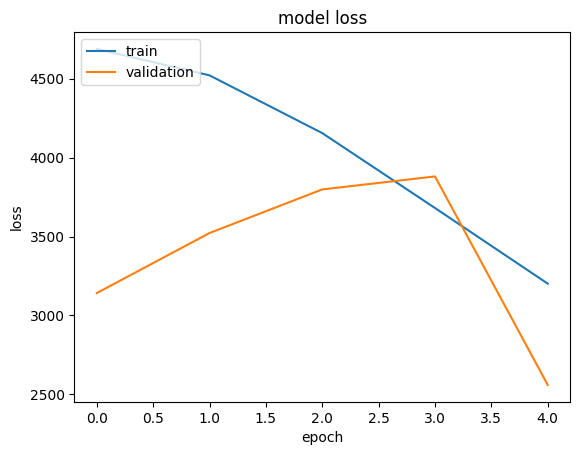

In [23]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='upper left')
plt.show()

### Plotting Actual vs Predictions on the same plot

In [24]:
train_solar_pred = solar_model.predict(X_solar_train)
val_solar_pred = solar_model.predict(X_solar_valid)
test_solar_pred = solar_model.predict(X_solar_test)

191/191 ━━━━━━━━━━━━━━━━━━━━ 2s 11ms/step
41/41 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step
41/41 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step


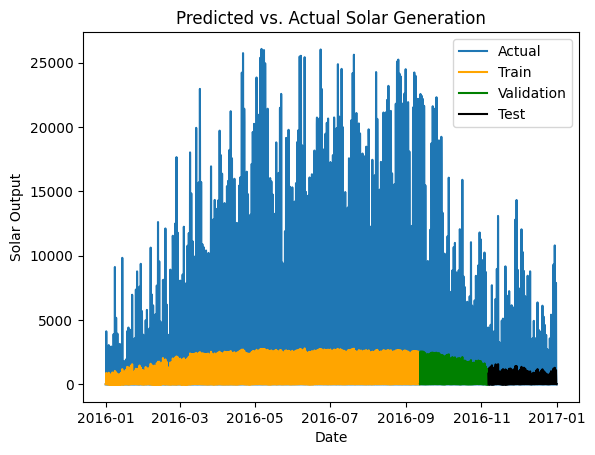

In [26]:
df = dataset[['DE_solar_generation_actual']]

train_df = train[['DE_solar_generation_actual']]
train_df.loc[:, 'DE_solar_generation_actual'] = train_solar_pred

valid_df = valid[['DE_solar_generation_actual']]
valid_df.loc[:, 'DE_solar_generation_actual'] = val_solar_pred

test_df = test[['DE_solar_generation_actual']]
test_df.loc[:, 'DE_solar_generation_actual'] = test_solar_pred

# # Plot all predictions
inversetransform, =plt.plot(df, label = 'Actual')
train_solar_predx, =plt.plot(train_df, color='orange', label = 'Train')
val_solar_predx, =plt.plot(valid_df, color='green', label = 'Validation')
test_solar_predx, =plt.plot(test_df, color='black', label = 'Test')
plt.xlabel('Date')
plt.ylabel('Solar Output')
plt.legend(loc="upper right")
plt.title("Predicted vs. Actual Solar Generation")
plt.show()

### Regression Metrics for Solar

In [27]:
metrics('cnn+lstm', test[['DE_solar_generation_actual']], test_solar_pred)

,MAE,MSE,RMSE,RMSLE,R2
model,,,,,
cnn+lstm,975.906365,4951711.030969,2225.244039,7.707622,0.10727


## Building the model for Wind Dataset

In [28]:
digit_a = Input(shape=(4,))

x = Reshape((-1,1))(digit_a)

x = Conv1D(128, 2)(x)
x = BatchNormalization()(x)
x = Conv1D(128, 2)(x)
x = BatchNormalization()(x)
x = Conv1D(128, 2)(x)
x = BatchNormalization()(x)

out_a = TimeDistributed(Flatten())(x)

out = LSTM(1024, input_shape = train.shape, return_sequences=False)(out_a)

out = Dense(1024)(out)

out = BatchNormalization()(out)
out = Dense(1)(out)

wind_model = Model(digit_a, out)
solar_model.summary()

Model: "functional_5"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_2 (InputLayer)      │ (None, 4)              │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ reshape_2 (Reshape)             │ (None, 4, 1)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d_6 (Conv1D)               │ (None, 3, 128)         │           384 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_8           │ (None, 3, 128)         │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d_7 (Conv1D)               │ (None, 2, 128)         │        32,896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_9           │ (None, 2, 128)         │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d_8 (Conv1D)               │ (None, 1, 128)         │        32,896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_10          │ (None, 1, 128)         │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ time_distributed_2              │ (None, 1, 128)         │             0 │
│ (TimeDistributed)               │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_2 (LSTM)                   │ (None, 1024)           │     4,722,688 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_4 (Dense)                 │ (None, 1024)           │     1,049,600 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_11          │ (None, 1024)           │         4,096 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_5 (Dense)                 │ (None, 1)              │         1,025 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 17,529,733 (66.87 MB)

 Trainable params: 5,842,305 (22.29 MB)

 Non-trainable params: 2,816 (11.00 KB)

 Optimizer params: 11,684,612 (44.57 MB)

## Fitting the same model for Wind Dataset

In [29]:
wind_model.compile(optimizer = 'adam', loss = 'mean_absolute_error')
history = wind_model.fit(X_wind_train, y_wind_train, validation_data=(X_wind_valid, y_wind_valid), epochs=5)

# take the mean absolute error again with another optimizer and check the accuracy

Epoch 1/5
191/191 ━━━━━━━━━━━━━━━━━━━━ 27s 116ms/step - loss: 1.2894 - val_loss: 0.4634
Epoch 2/5
191/191 ━━━━━━━━━━━━━━━━━━━━ 20s 107ms/step - loss: 0.3181 - val_loss: 0.4511
Epoch 3/5
191/191 ━━━━━━━━━━━━━━━━━━━━ 21s 110ms/step - loss: 0.3120 - val_loss: 0.2728
Epoch 4/5
191/191 ━━━━━━━━━━━━━━━━━━━━ 24s 127ms/step - loss: 0.3742 - val_loss: 0.3552
Epoch 5/5
191/191 ━━━━━━━━━━━━━━━━━━━━ 21s 110ms/step - loss: 0.3280 - val_loss: 0.2964


In [30]:
wind_model.evaluate(X_wind_test, y_wind_test)

41/41 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.2672


0.29417598247528076

## Model's Loss for Wind Dataset

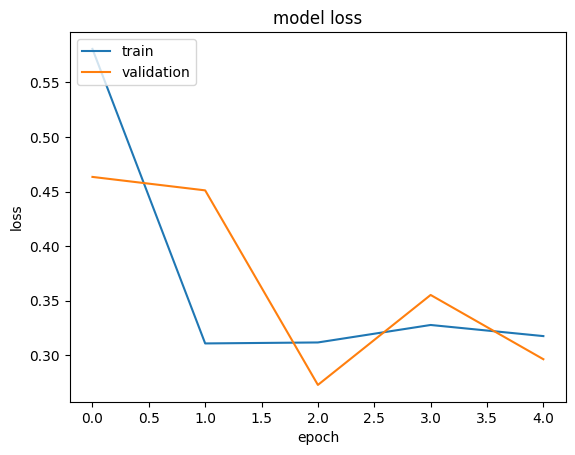

In [31]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='upper left')
plt.show()

## Actual vs Predicted for Wind on same graph

In [32]:
train_wind_pred = wind_model.predict(X_wind_train)
val_wind_pred = wind_model.predict(X_wind_valid)
test_wind_pred = wind_model.predict(X_wind_test)

191/191 ━━━━━━━━━━━━━━━━━━━━ 2s 10ms/step
41/41 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step
41/41 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step


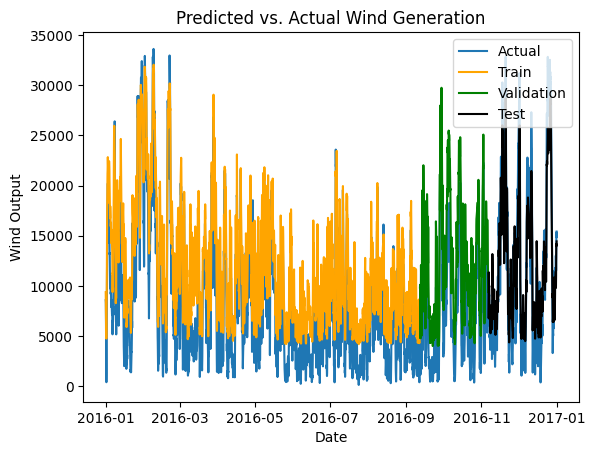

In [33]:
df = dataset[['DE_wind_generation_actual']]

train_df = train[['DE_wind_generation_actual']]
train_df.loc[:, 'DE_wind_generation_actual'] = scaler.inverse_transform(train_wind_pred)

valid_df = valid[['DE_wind_generation_actual']]
valid_df.loc[:, 'DE_wind_generation_actual'] = scaler.inverse_transform(val_wind_pred)

test_df = test[['DE_wind_generation_actual']]
test_df.loc[:, 'DE_wind_generation_actual'] = scaler.inverse_transform(test_wind_pred)

inversetransform, =plt.plot(df, label = 'Actual')
train_wind_predx, =plt.plot(train_df, color='orange', label = 'Train')
val_wind_predx, =plt.plot(valid_df, color='green', label = 'Validation')
test_wind_predx, =plt.plot(test_df, color='black', label = 'Test')

plt.xlabel('Date')
plt.ylabel('Wind Output')
plt.legend(loc="upper right")
plt.title("Predicted vs. Actual Wind Generation")
plt.show()

### Regression Metrics for Wind

In [34]:
metrics('cnn+lstm', test[['DE_wind_generation_actual']], scaler.inverse_transform(test_wind_pred))

,MAE,MSE,RMSE,RMSLE,R2
model,,,,,
cnn+lstm,2543.024637,8948548.520035,2991.412462,8.003501,0.880253
